In [1]:
import pandas as pd
import numpy as np
import preprocess
import group_calc
import factor_analysis

# 载入数据

In [2]:
# 读取数据
factor_df=pd.read_csv('./data/factor_df.csv')
bp_df = pd.read_csv('./data/pb.csv')
ret_df=pd.read_csv('./data/ret_df.csv')
mktmv_df = pd.read_csv('./data/mktmv_df.csv')
benchmark = pd.read_csv('./data/index_ret.csv')
ind_df=pd.read_csv('./data/ind_df.csv')
# 处理股票代码
codefunc1=lambda x: '{:0>6}'.format(x)
factor_df['stock_code']=factor_df['stock_code'].apply(codefunc1)
bp_df['stock_code']=bp_df['stock_code'].apply(codefunc1)
ret_df['stock_code']=ret_df['stock_code'].apply(codefunc1)
mktmv_df['stock_code']=mktmv_df['stock_code'].apply(codefunc1)
ind_df['stock_code']=ind_df['stock_code'].apply(codefunc1)
# 处理日期
codefunc2 = lambda x: x if np.isnan(x) else str(int(x))
factor_df['trade_date']=factor_df['trade_date'].apply(codefunc2)
bp_df['trade_date']=bp_df['trade_date'].apply(codefunc2)
ret_df['trade_date']=ret_df['trade_date'].apply(codefunc2)
mktmv_df['trade_date']=mktmv_df['trade_date'].apply(codefunc2)
ind_df['trade_date']=ind_df['trade_date'].apply(codefunc2)
benchmark['trade_date'] = benchmark['trade_date'].apply(codefunc2)
ind_df

,trade_date,stock_code,ind_code
0,20080104,000001,银行
1,20080104,000002,房地产
2,20080104,000003,综合
3,20080104,000004,房地产
4,20080104,000005,房地产
...,...,...,...
1069697,20170120,603993,有色金属
1069698,20170120,603996,家用电器
1069699,20170120,603997,汽车
1069700,20170120,603998,医药生物


# 预处理

In [3]:
# 处理factor因子
# MAD去极值
factor_df = preprocess.del_outlier(factor_df, 'factor', method='mad', n=3)
# 排序标准化
factor_df = preprocess.standardize(factor_df, 'factor', method='rank')
# 同时做市值中性化和行业中性化
factor_df=preprocess.neutralize(factor_df=factor_df,
                                 factor_name='factor',
                                 mktmv_df=mktmv_df,
                                 industry_df=ind_df)
factor_df

,trade_date,stock_code,factor
0,20080104,000002,-0.063932
1,20080104,000006,1.554653
2,20080104,000009,-1.209667
3,20080104,000011,0.755748
4,20080104,000012,0.321442
...,...,...,...
739903,20170120,603866,-0.328641
739904,20170120,603868,-1.177365
739905,20170120,603883,-0.253072
739906,20170120,603993,-0.431949


In [4]:
# bp因子也做同样处理
bp_df['bp'] = -bp_df['pb'] 
bp_df=bp_df.drop(columns=['pb'])
# MAD去极值
bp_df = preprocess.del_outlier(bp_df, 'bp', method='mad', n=3)
# 排序标准化
bp_df = preprocess.standardize(bp_df, 'bp', method='rank')
# 同时做市值中性化和行业中性化
bp_df=preprocess.neutralize(factor_df=bp_df,
                                 factor_name='bp',
                                 mktmv_df=mktmv_df,
                                 industry_df=ind_df)
bp_df

,trade_date,stock_code,bp
0,20080104,000001,-1.146309
1,20080104,000002,0.622134
2,20080104,000004,-1.230210
3,20080104,000005,-0.468167
4,20080104,000006,0.746799
...,...,...,...
957728,20170120,603993,-0.086327
957729,20170120,603996,-0.195609
957730,20170120,603997,-0.598758
957731,20170120,603998,-0.878680


# 分组收益率计算

In [5]:
mw_group_ret = group_calc.get_group_ret(factor_df, ret_df, 'factor', 5, mktmv_df)
mw_group_ret

,Group0,Group1,Group2,Group3,Group4,H-L
20080111,0.017009,0.010774,0.028362,0.025421,0.025821,0.008812
20080118,-0.070097,-0.064212,-0.110490,-0.093907,-0.098111,-0.028014
20080125,-0.053619,-0.085627,-0.083686,-0.080304,-0.093220,-0.039601
20080201,-0.007342,0.025003,0.054985,0.040370,0.043941,0.051283
20080205,0.034339,0.010622,0.014355,0.014010,0.017164,-0.017176
...,...,...,...,...,...,...
20161223,0.004802,0.001227,-0.002790,-0.001955,0.010843,0.006041
20161230,-0.001131,0.008190,0.009159,0.005607,0.000331,0.001463
20170106,0.004718,0.014047,0.014315,0.009883,0.016821,0.012103
20170113,-0.068352,-0.039939,-0.033534,-0.048792,-0.041395,0.026958


# 因子分析

In [6]:
factor_analysis.newy_west_test(mw_group_ret['H-L'],'factor')

{'factor_name': ['factor'],
 'ret_mean(%)': [0.465],
 't-value': [4.591],
 'p-value': [0.0],
 'p-star': ['***']}

# IC检验

     因子名称      IC均值     IC标准差      IR比率  IC>0的比例(%)  IC>0.02的比例(%)
0  factor  0.038465  0.096526  0.398493   64.578834      58.531317


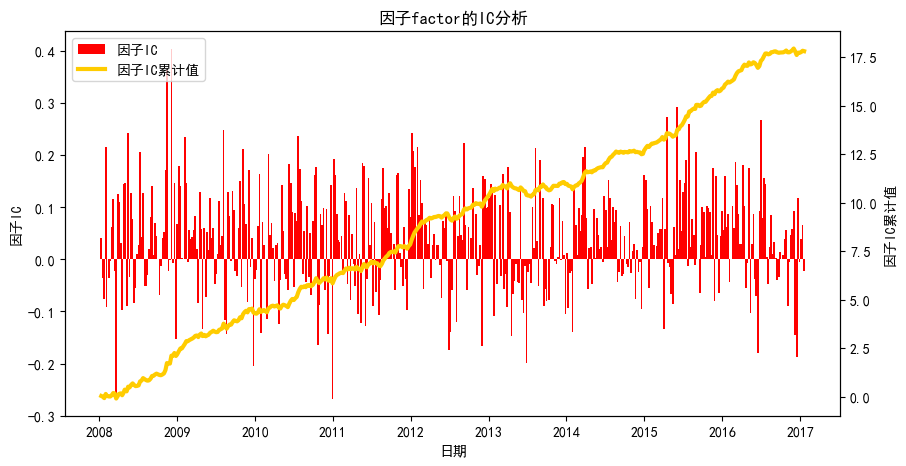

In [7]:
ic_dct, ic_fig = factor_analysis.analysis_factor_ic(factor_df, ret_df, 'factor')
print(pd.DataFrame(ic_dct))
ic_fig

# 净值曲线

In [8]:
ew_backtest_df,ew_fig1,ew_fig2=group_calc.analysis_group_ret(factor_df, ret_df, 'factor', n_groups=5, benchmark=benchmark, mktmv_df=None)
ew_backtest_df

,Group0,Group1,Group2,Group3,Group4,H-L,benchmark
年化收益率(%),-62.202763,-24.090990,12.204614,46.921463,62.668103,316.955181,-23.465720
年化波动率(%),86.483063,85.703836,86.046216,85.300000,87.533546,24.696280,62.750575
夏普比率,-0.719248,-0.281096,0.141838,0.550076,0.715932,12.834127,-0.373952
最大回撤(%),-84.236588,-78.835010,-78.802782,-77.075193,-76.503114,-9.756263,-70.808614
超额年化收益率(%),-50.613977,-0.816980,46.607004,91.968180,112.542803,444.795331,0.000000
超额年化波动率(%),67.202728,65.126617,63.779180,62.288155,63.268004,62.059432,0.000000
信息比率,-0.753154,-0.012544,0.730756,1.476495,1.778827,7.167248,0.000000
相对基准胜率(%),48.596112,55.291577,57.235421,57.235421,59.395248,54.643629,0.000000
超额收益最大回撤(%),-77.081527,-42.416827,-41.913014,-36.685585,-35.834882,-46.730176,0.000000


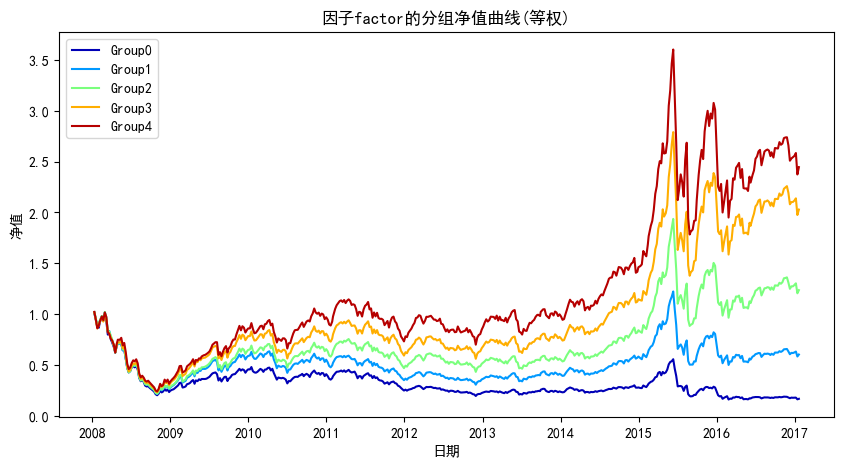

In [9]:
ew_fig1

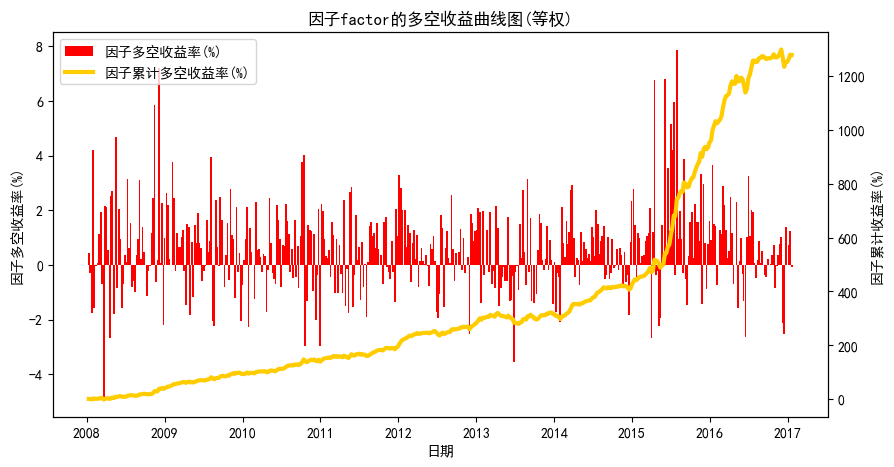

In [10]:
ew_fig2

In [11]:
mw_backtest_df,mw_fig1,mw_fig2=group_calc.analysis_group_ret(factor_df, ret_df, 'factor', n_groups=5, mktmv_df=mktmv_df)
mw_backtest_df

,Group0,Group1,Group2,Group3,Group4,H-L
年化收益率(%),-65.779073,-51.754734,-30.364634,-18.411843,7.509155,207.214266
年化波动率(%),75.292173,77.891808,76.655887,76.458302,79.518161,31.173830
夏普比率,-0.873651,-0.664444,-0.396116,-0.240809,0.094433,6.647058
最大回撤(%),-87.314994,-79.451460,-79.316866,-77.564071,-76.703663,-17.304287


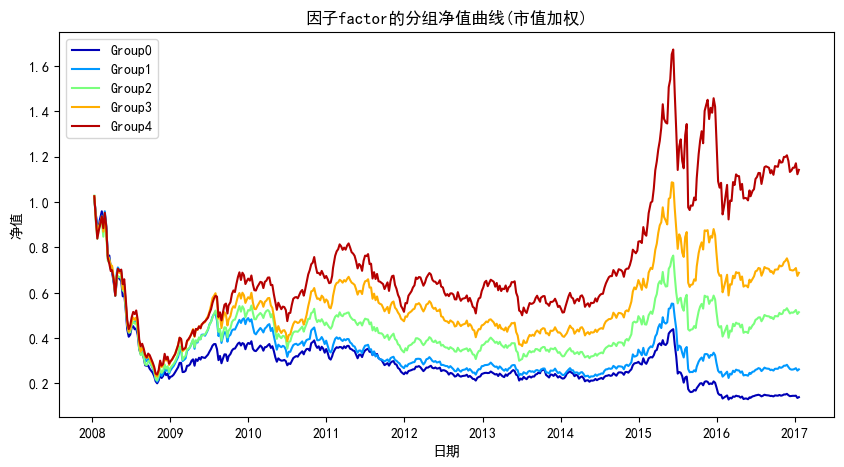

In [12]:
mw_fig1

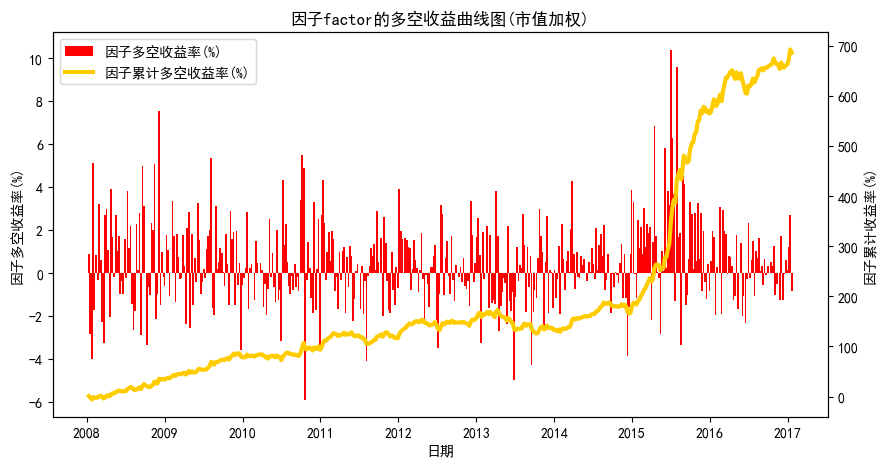

In [13]:
mw_fig2

# 序贯双重排序

In [14]:
db_sort_group_ret = group_calc.get_double_sort_group_ret(
    bp_df,
    factor_df,
    ret_df,
    "bp",
    "factor",
    5,
    5,
    mktmv_df=mktmv_df,
)
db_sort_group_ret

,trade_date,bp_group,factor_group,ret
0,20080111,Group0,Group0,0.032646
1,20080111,Group0,Group1,-0.004857
2,20080111,Group0,Group2,0.034856
3,20080111,Group0,Group3,0.008934
4,20080111,Group0,Group4,0.034988
...,...,...,...,...
13885,20170120,Group4,Group1,0.031743
13886,20170120,Group4,Group2,0.027323
13887,20170120,Group4,Group3,0.025269
13888,20170120,Group4,Group4,0.028162


In [15]:
db_sort_mean_df = group_calc.double_sort_mean(db_sort_group_ret,"bp","factor")
db_sort_mean_df

Group0  Group1  Group2  Group3  Group4    H-L
Group0 ret_mean(%)  -0.426  -0.223  -0.067  -0.128  -0.033  0.392
       t-value      -1.334  -0.473  -0.445  -0.074   0.174  3.375
Group1 ret_mean(%)  -0.361  -0.122  -0.119  -0.019   0.049  0.410
       t-value      -1.080  -1.221  -0.352   0.251   0.731  4.270
Group2 ret_mean(%)  -0.290  -0.306  -0.088   0.067   0.194  0.484
       t-value      -0.566  -0.273  -0.020   0.368   0.649  2.522
Group3 ret_mean(%)  -0.141  -0.072  -0.005   0.092   0.165  0.307
       t-value      -0.293   0.340   0.658   0.958   1.328  3.441
Group4 ret_mean(%)  -0.074   0.092   0.166   0.248   0.338  0.412
       t-value      -1.688  -0.889  -0.269  -0.478  -0.125  3.093

In [16]:
db_sort_backtest_df = group_calc.double_sort_backtest(db_sort_group_ret, "bp", "factor", benchmark=None, period="WEEKLY")
db_sort_backtest_df

Group0     Group1     Group2     Group3     Group4  \
Group0 年化收益率(%) -24.713124 -16.671456  -9.773950 -13.163945  -9.040385   
       年化波动率(%)  34.384957  35.928046  36.316487  37.841960  38.622769   
       夏普比率      -0.718719  -0.464023  -0.269133  -0.347866  -0.234069   
       最大回撤(%)  -92.561782 -81.040818 -79.859179 -81.346667 -78.720100   
Group1 年化收益率(%) -22.928369 -12.422766 -12.697089  -7.624697  -5.563682   
       年化波动率(%)  37.079864  36.537852  37.829036  36.787273  39.923296   
       夏普比率      -0.618351  -0.339997  -0.335644  -0.207265  -0.139359   
       最大回撤(%)  -90.422430 -77.530129 -84.509686 -80.125221 -81.628468   
Group2 年化收益率(%) -20.141255 -20.622749 -10.923683  -3.362297   2.469465   
       年化波动率(%)  37.711502  37.016735  36.742410  36.697387  38.494297   
       夏普比率      -0.534088  -0.557120  -0.297304  -0.091622   0.064151   
       最大回撤(%)  -86.917226 -88.680177 -81.787913 -78.991586 -76.347005   
Group3 年化收益率(%) -13.321119 -10.508301  -7.128598  -1.829696   1.809875   
       年化波动率(%)  36.449049  37.709535  37.227039  35.991862  36.452109   
       夏普比率      -0.365472  -0.278664  -0.191490  -0.050836   0.049651   
       最大回撤(%)  -80.159774 -83.412490 -78.798398 -75.756506 -76.400224   
Group4 年化收益率(%) -10.929484  -3.039184   1.241764   6.010447  11.346206   
       年化波动率(%)  38.576670  38.953991  37.800401  37.127663  36.432277   
       夏普比率      -0.283318  -0.078020   0.032851   0.161886   0.311433   
       最大回撤(%)  -77.590753 -76.797015 -77.703317 -76.443445 -72.806182   

                       H-L  
Group0 年化收益率(%)  20.170517  
       年化波动率(%)  19.902426  
       夏普比率       1.013470  
       最大回撤(%)  -21.479671  
Group1 年化收益率(%)  21.562137  
       年化波动率(%)  18.797991  
       夏普比率       1.147045  
       最大回撤(%)  -35.485144  
Group2 年化收益率(%)  26.287029  
       年化波动率(%)  18.874146  
       夏普比率       1.392753  
       最大回撤(%)  -23.763252  
Group3 年化收益率(%)  15.465829  
       年化波动率(%)  17.671310  
       夏普比率       0.875194  
       最大回撤(%)  -22.762711  
Group4 年化收益率(%)  21.847050  
       年化波动率(%)  18.221476  
       夏普比率       1.198973  
       最大回撤(%)  -22.875735

# Fama-Macbeth回归

In [17]:
two_factor_df = pd.merge(factor_df, bp_df, on=['trade_date', 'stock_code'])
fmreg_res_dct = factor_analysis.fama_macbeth_reg(ret_df, two_factor_df, ['factor', 'bp'])
fmreg_res_dct

{'factor_name': ['factor', 'bp'],
 'beta': [0.001954556584464449, 0.0011057229592904433],
 't-value': [6.986433993363169, 3.6404282777536707],
 'R-square': 0.0008161765509724361,
 'Average-Obs': 1591.1749460043197}